In [1]:
import jax
import jax.numpy as jnp
import jax.random as jxr
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import matplotlib
from functools import partial
from tqdm import tqdm
import seaborn as sns

import sys
sys.path.append('../')
import utils
from models import wGPLDS, WeightSpaceGaussianProcess
import pickle

/Users/victorgeadah_maciii/anaconda3/envs/fi_gp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def nonnormality_metric(A):
    return jnp.sqrt(jnp.linalg.norm(A, ord='fro') - jnp.linalg.norm(jnp.linalg.eigvals(A)))

assert jnp.isclose(nonnormality_metric(jnp.eye(3)), 0.)

In [3]:
def load_data(event):
    Y  = jnp.load(f'/Users/victorgeadah_maciii/Documents/3_Research/Flatiron/kiani_lab/X/Y_N20170102_{event}.npy')
    U  = jnp.load(f'/Users/victorgeadah_maciii/Documents/3_Research/Flatiron/kiani_lab/X/U_N20170102_{event}.npy')
    t_range = jnp.load(f'/Users/victorgeadah_maciii/Documents/3_Research/Flatiron/kiani_lab/X/t_range_{event}.npy')
    coherencies  = jnp.load(f'/Users/victorgeadah_maciii/Documents/3_Research/Flatiron/kiani_lab/X/coherencies_{event}.npy')

    # # Preprocess data
    # Y -= Y.mean() # axis=2, keepdims=True
    # Y /= Y.std()

    Y = Y.reshape(-1, Y.shape[-2], Y.shape[-1])
    U = U.reshape(-1, U.shape[-2], U.shape[-1]).transpose(0, 2, 1)
    print('Shape (coheriences * trials) x time x neurons :', Y.shape)

    _, coherence_indices = jnp.unique(U[:,0,1], return_index=True)

    return Y, U, t_range, coherencies, coherence_indices

In [7]:
# Import Kiani lab data

# event = 'dots_on_screen'
event = 'out_fp_wd'
Y, U, t_range, coherencies, coherence_indices = load_data(event)

partition = 0.8
n_trials = Y.shape[0]
n_train = int(n_trials * partition)
n_test = n_trials - n_train

# Randomly shuffle trials and pick training and test sets
key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)
perm = jax.random.permutation(subkey, n_trials)

Y = Y[perm]
U = U[perm]
coherencies = coherencies[perm]
coherence_indices = coherence_indices[perm]
Y_train = Y[:n_train]
U_train = U[:n_train]

Shape (coheriences * trials) x time x neurons : (117, 34, 89)


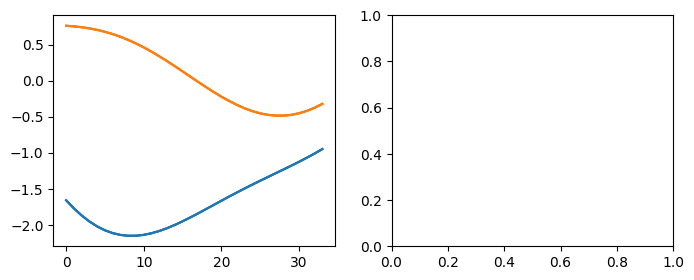

In [8]:
# Define model

latent_dim = 20
n_neurons = Y.shape[-1]

_sigma, _kappa, t_period, c_period = 1.0, 0.15, 5*0.3, 4.0
torus_basis_funcs = utils.T2_basis(5, _sigma, _kappa, t_period, c_period)

A_prior = WeightSpaceGaussianProcess(torus_basis_funcs, D1=latent_dim, D2=latent_dim)
# b_prior = WeightSpaceGaussianProcess(torus_basis_funcs, D1=latent_dim, D2=1)
model = wGPLDS(
    wgps={
        'A': A_prior, 
        'b': None,
        'C': None,
        }, 
    state_dim=latent_dim, 
    emission_dim=n_neurons,
    )

# conditions = jnp.vstack([t_range, coherencies[7] * jnp.ones_like(t_range)])

fig, axs = plt.subplots(ncols=2, figsize=[8,3])
for i in coherence_indices[:3]:
    axs[0].plot(A_prior.sample(jxr.PRNGKey(0), U[i])[:,0,0], c='tab:blue');
    axs[0].plot(A_prior.sample(jxr.PRNGKey(0), U[i])[:,0,1], c='tab:orange');

# for j in range(3):
#     axs[1].plot(coherencies, A_prior.sample(jxr.PRNGKey(0), U[j])[:,1,0], c='tab:blue');
#     axs[1].plot(coherencies, A_prior.sample(jxr.PRNGKey(0), U[j])[:,1,1], c='tab:orange');
# .set_title('A prior samples');

Iter 1/100, log-prob = -2319296.00, marginal log-lik = -2375609.75
Iter 2/100, log-prob = -350638.22, marginal log-lik = -408239.84
Iter 3/100, log-prob = -316773.81, marginal log-lik = -374374.25
Iter 4/100, log-prob = -313935.12, marginal log-lik = -371536.56
Iter 5/100, log-prob = -312888.84, marginal log-lik = -370490.31
Iter 6/100, log-prob = -312227.00, marginal log-lik = -369828.50
Iter 7/100, log-prob = -311705.84, marginal log-lik = -369307.31
Iter 8/100, log-prob = -311294.81, marginal log-lik = -368896.25
Iter 9/100, log-prob = -310956.69, marginal log-lik = -368558.06
Iter 10/100, log-prob = -310678.97, marginal log-lik = -368280.31
Iter 11/100, log-prob = -310443.69, marginal log-lik = -368045.00
Iter 12/100, log-prob = -310243.00, marginal log-lik = -367844.25
Iter 13/100, log-prob = -310067.56, marginal log-lik = -367668.75
Iter 14/100, log-prob = -309912.94, marginal log-lik = -367514.09
Iter 15/100, log-prob = -309774.28, marginal log-lik = -367375.38
Iter 16/100, log-

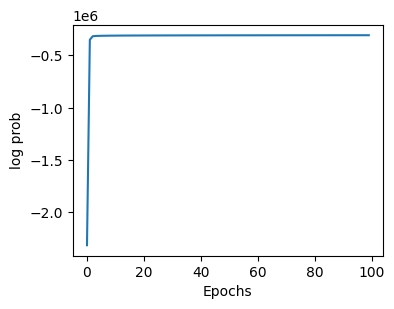

In [11]:
from models import ParamswGPLDS

num_timesteps = Y.shape[1]

# Initialize
seed = 0
A_key, b_key, C_key = jxr.split(jxr.PRNGKey(seed), 3)
initial_params = ParamswGPLDS(
    dynamics_gp_weights = A_prior.sample_weights(A_key),
    Q = 0.05 * jnp.eye(latent_dim),
    R = 0.05 * jnp.eye(n_neurons),
    m0 = jnp.zeros(latent_dim),
    S0 = jnp.eye(latent_dim),
    Cs = jnp.tile(jxr.normal(C_key, (n_neurons, latent_dim)), (num_timesteps, 1, 1)),
    bs = jnp.zeros((num_timesteps-1, latent_dim)), #b_prior.sample(b_key, conditions).squeeze(),
    bias_gp_weights = None,
    emissions_gp_weights = None,
)

# Fit model
params, log_probs = model.fit_em(initial_params, emissions=Y_train, inputs=U_train, num_iters=100)

# Show results
fig, ax = plt.subplots(figsize=[4,3])
ax.plot(log_probs)
ax.set_ylabel('log prob')
ax.set_xlabel('Epochs');

In [ ]:
# the log-prior sums D x D components, so lp will go up as D^2. compare MLLs.
# Ndim = 10, kappa = 0.2, mll = -468210.94
# Ndim = 10, kappa = 0.1, mll = -466157.50
# Ndim = 2, kappa = 0.05, mll = -471319.72
# Ndim = 5, kappa = 0.05, mll = -469101.69
# Ndim = 10, kappa = 0.05, mll = -465505.56
# Ndim = 20, kappa = 0.05, mll = -459091.88
# Ndim = 30, kappa = 0.05, mll = -450868.50
# Ndim = 50, kappa = 0.05, mll = -427183.22
# Ndim = 10, kappa = 0.005, mll = -465363.41
# Ndim = 20, kappa = 0.1, mll = -460006.06
# Ndim = 20, kappa = 0.2, mll = -463253.16

# out fp wd
# ndim = 20, kappa = 0.05, mll = -454498.09
# ndim = 20, kappa = 0.1, mll = -457363.28

# plt.plot([2,5,10,20,30,50], [-471319.72, -469101.69, -465505.56, -459091.88, -450868.50, -427183.22], '-o') # vary dim
# plt.plot([0.2, 0.1, 0.05, 0.005], [-468210.94, -466157.50, -465505.56, -465363.41], '-o') # vary lenghtscale
# plt.xscale('log')

In [56]:
import pickle
savedir = '/Users/victorgeadah_maciii/Documents/3_Research/Flatiron/gplds/saves/kianilab/'
with open(savedir+f'params_{event}_kappa{_kappa}.pkl', 'wb') as f:
    pickle.dump(params, f)

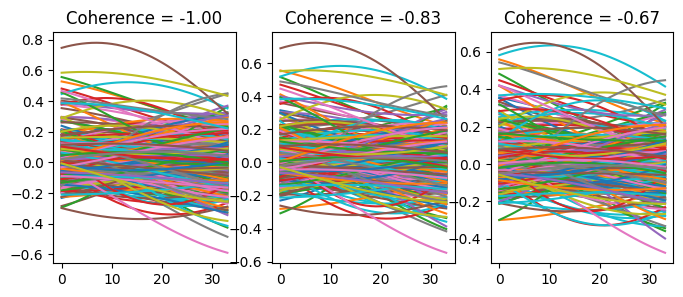

In [46]:
fig, axs = plt.subplots(ncols=3, figsize=[8,3])

for i in range(3):
    As = A_prior(params.dynamics_gp_weights, U[coherence_indices[i]])
    axs[i].plot(As.reshape(len(U[i]), -1));
    axs[i].set_title('Coherence = %.2f' % U[coherence_indices[i], 0,1])

# Plot eigenvalues as function of time
# eigenvals = jnp.linalg.eigvals(As)
# eigenvals = jnp.sort(eigenvals.real, axis=1)
# plt.plot(t_range[:-1], eigenvals);

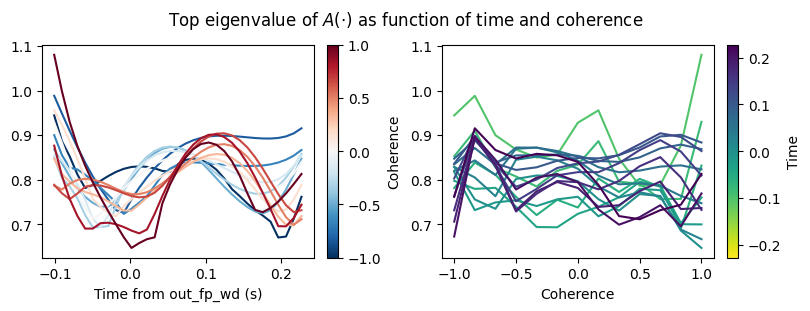

In [57]:
import matplotlib

eigenvals = []
for i in range(len(coherencies)):
    As = A_prior(params.dynamics_gp_weights, U[coherence_indices[i]])
    vals = jnp.array([jnp.sort(jnp.linalg.eigvals(As[t]).real)[-1] for t in range(len(t_range)-1)])
    # vals = jnp.array([jnp.linalg.det(As[t]) for t in range(len(t_range)-1)])
    # vals = jnp.array([nonnormality_metric(As[t]) for t in range(len(t_range)-1)])
    eigenvals.append(vals)

eigenvals = jnp.stack(eigenvals)

c_sm = plt.cm.ScalarMappable(cmap='RdBu_r', norm=plt.Normalize(vmin=min(coherencies), vmax=max(coherencies)))
c_colors = c_sm.to_rgba(coherencies)
t_sm = plt.cm.ScalarMappable(cmap='viridis_r', norm=matplotlib.colors.CenteredNorm(vcenter=0.))
t_colors = t_sm.to_rgba(t_range[:-1])

fig, axs = plt.subplots(ncols=2, figsize=[8,3], constrained_layout=True)
for i in range(len(coherencies)):
    axs[0].plot(t_range[:-1], eigenvals[i], color=c_colors[i]);
# axs[0].axhline(1.0, color='k', linestyle='--', zorder=-1);
axs[0].set_xlabel(f'Time from {event} (s)');
fig.colorbar(c_sm, ax=axs[0], orientation='vertical', label='Coherence');

for i in range(len(t_range)-1)[::2]:
    axs[1].plot(coherencies, eigenvals[:,i], color=t_colors[i]);
# axs[1].plot(coherencies, eigenvals[:,15], alpha=0.5);
# axs[1].plot(coherencies, eigenvals[:,-1], alpha=0.5);
# axs[1].axhline(1.0, color='k', linestyle='--', zorder=-1);
axs[1].set_xlabel('Coherence')
axs[1].sharey(axs[0]);
fig.colorbar(t_sm, ax=axs[1], orientation='vertical', label='Time');

fig.suptitle('Top eigenvalue of $A(\cdot)$ as function of time and coherence');
# plt.savefig(f'figures/eigenvalues_{event}.png', dpi=300)

In [ ]:
fig, ax = plt.subplots()
ax.plot(jnp.linalg.eigvals(As[0]).real, jnp.linalg.eigvals(As[0]).imag, 'o')
ax.plot(jnp.linalg.eigvals(As[-1]).real, jnp.linalg.eigvals(As[-1]).imag, 'o')
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1.5, 1.5])


In [34]:
def reconstruct_y(b):
    _, (filtered_means, _), (smoothed_means, smoothed_covs, _) = model.smoother(params, Y[b], U[b])
    _reconstructed_ys = jnp.einsum('tnl,tl->tn', params.Cs, smoothed_means)
    return _reconstructed_ys

ValueError: x and y must have same first dimension, but have shapes (34,) and (31,)

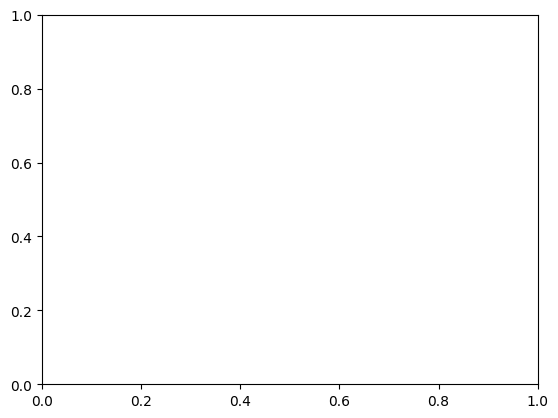

In [33]:
# all_reconstructed_ys = []
# for b in tqdm(range(len(Y))):
#     _, (filtered_means, _), (smoothed_means, smoothed_covs, _) = model.smoother(params, Y[b], U[b])
#     reconstructed_ys = jnp.einsum('tnl,tl->tn', params.Cs, smoothed_means)
#     reconstructed_ys_covs = jnp.einsum('tnl,tlk,tmk->tnm', params.Cs, smoothed_covs, params.Cs)
#     self_smoothed_covs = jnp.stack([jnp.diag(reconstructed_ys_covs[t]) for t in range(reconstructed_ys_covs.shape[0])])
#     all_reconstructed_ys.append(reconstructed_ys)

def reconstruct_y(b):
    _, (filtered_means, _), (smoothed_means, smoothed_covs, _) = model.smoother(params, Y[b], U[b])
    _reconstructed_ys = jnp.einsum('tnl,tl->tn', params.Cs, smoothed_means)
    return _reconstructed_ys

reconstructed_ys = jax.vmap(reconstruct_y)(jnp.arange(len(Y)))
fig, ax = plt.subplots();
for i in range(n_neurons):
    ax.plot(t_range, Y.mean(0)[:,i], c='k', alpha=0.1)
    ax.plot(t_range, reconstructed_ys.mean(0)[:,i], c='tab:orange', alpha=0.1)

ax.plot(t_range, Y.mean(0).mean(1), c='k', label='Data')
ax.plot(t_range, reconstructed_ys.mean(0).mean(1), c='tab:orange', label='Model')
ax.set_ylabel('Firing rate')
ax.set_xlabel(f'Time from {event} (s)')
ax.set_title('Reconstruction per neuron, averaged over trials')
ax.axvline(x=0, c='tab:gray', zorder=-1);
ax.legend();
# plt.savefig(f'figures/reconstruction_{event}.png')

Shape (coheriences * trials) x time x neurons : (117, 31, 89)
Shape (coheriences * trials) x time x neurons : (117, 34, 89)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


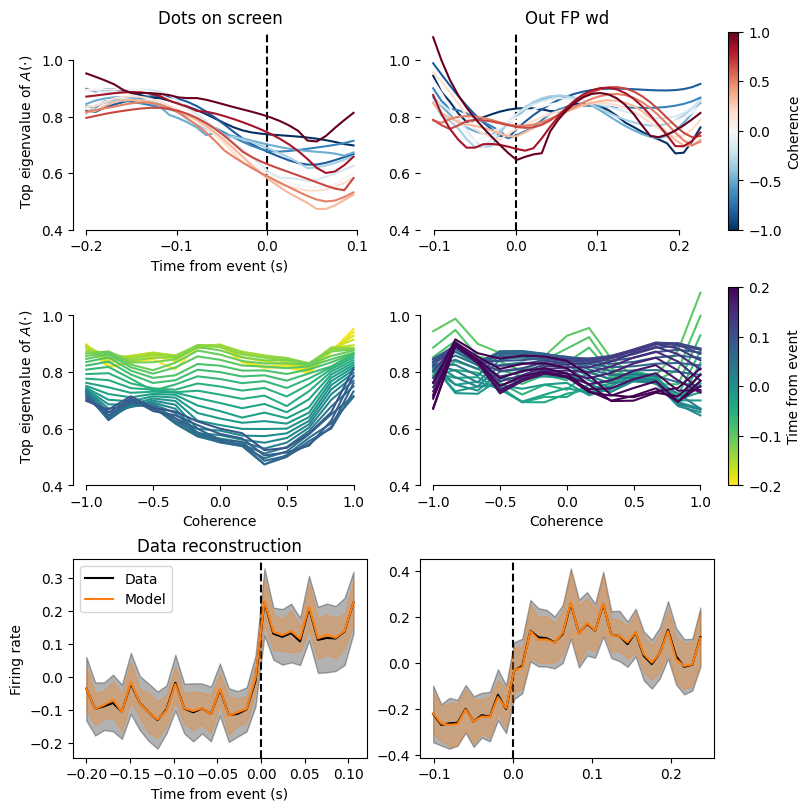

In [79]:
# Global constants
latent_dim = 20
sigma, t_period, c_period = 1.0, 5*0.3, 4.0
savedir = '/Users/victorgeadah_maciii/Documents/3_Research/Flatiron/gplds/saves/kianilab/'

# Plot specific
kappa = 0.15

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=[8,8], constrained_layout=True)
t_sm = plt.cm.ScalarMappable(cmap='viridis_r', norm=matplotlib.colors.CenteredNorm(vcenter=0.))
c_sm = plt.cm.ScalarMappable(cmap='RdBu_r', norm=plt.Normalize(vmin=-1.0, vmax=1.0))

for event_id, event in enumerate(['dots_on_screen', 'out_fp_wd']):

    _params = pickle.load(open(savedir+f'params_{event}_kappa{kappa}.pkl', 'rb'))
    
    # Load data
    Y, U, t_range, coherencies, coherence_indices = load_data(event)
    t_range_p = t_range[:-1]

    # Format colors 
    t_colors = t_sm.to_rgba(t_range[:-1])
    c_colors = c_sm.to_rgba(coherencies)

    # Load prior
    torus_basis_funcs = utils.T2_basis(5, _sigma, kappa, t_period, c_period)
    A_prior = WeightSpaceGaussianProcess(torus_basis_funcs, D1=latent_dim, D2=latent_dim)
    model = wGPLDS({'A': A_prior}, state_dim=latent_dim, emission_dim=n_neurons)
    
    # Compute plotting values
    eigenvals = []
    for i in range(len(coherencies)):
        As = A_prior(_params.dynamics_gp_weights, U[coherence_indices[i]])
        vals = jnp.array([jnp.sort(jnp.linalg.eigvals(As[t]).real)[-1] for t in range(len(t_range_p))])
        # vals = jnp.array([nonnormality_metric(As[t]) for t in range(len(t_range)-1)])
        eigenvals.append(vals)
    eigenvals = jnp.stack(eigenvals)

    # Plot
    for i in range(len(coherencies)):
        axs[0,event_id].plot(t_range_p, eigenvals[i], color=c_colors[i]);

    
    for i in range(len(t_range_p)): #[::2]
    # for i in [0, 10, -1]:
        axs[1,event_id].plot(coherencies, eigenvals[:,i], color=t_colors[i]);
    axs[1,event_id].set_xlabel('Coherence')

    # Plot performance
    reconstruct_y = lambda b: jnp.einsum('tnl,tl->tn', _params.Cs, model.smoother(_params, Y[b], U[b])[2][0])
    reconstructed_ys = jax.vmap(reconstruct_y)(jnp.arange(len(Y)))

    # for i in range(n_neurons):
    #     axs[2, event_id].plot(t_range, Y.mean(0)[:,i], c='k', alpha=0.1)
    #     axs[2, event_id].plot(t_range, reconstructed_ys.mean(0)[:,i], c='tab:orange', alpha=0.1)

    _y_perneuron = reconstructed_ys.mean(0)
    axs[2, event_id].plot(t_range, Y.mean(0).mean(1), c='k', label='Data')
    axs[2, event_id].fill_between(
        t_range, 
        Y.mean(0).mean(1) - Y.mean(0).std(1), 
        Y.mean(0).mean(1) + Y.mean(0).std(1), 
        color='k', alpha=0.3
    )
    
    axs[2, event_id].plot(t_range, _y_perneuron.mean(1), c='tab:orange', label='Model')
    axs[2, event_id].fill_between(
        t_range, 
        _y_perneuron.mean(1) - _y_perneuron.std(1), 
        _y_perneuron.mean(1) + _y_perneuron.std(1), 
        color='tab:orange', alpha=0.3
        )
    
fig.colorbar(c_sm, ax=axs[0,1], orientation='vertical', label='Coherence');
fig.colorbar(t_sm, ax=axs[1,1], orientation='vertical', label='Time from event');

for ax in [axs[0,0], axs[0,1], axs[1,0], axs[1,1]]:
    ax.set_ylim([0.4, 1.1])
    # ax.axhline(y=1.0, c='tab:gray', zorder=-1)
    sns.despine(ax=ax, trim=True)

sns.despine(ax=axs[0,1], trim=True, left=True)
# axs[0,1].set_yticklabels([])
axs[0,0].axvline(x=0, c='k', ls='--', zorder=-1);
axs[0,1].axvline(x=0, c='k', ls='--', zorder=-1);
axs[0,0].set_xlabel(f'Time from event (s)');
# axs[0,1].set_xlabel(f'Time from event (s)');
axs[0,0].set_title('Dots on screen')
axs[0,1].set_title('Out FP wd')
axs[0,0].set_ylabel('Top eigenvalue of $A(\cdot)$')
axs[1,0].set_ylabel('Top eigenvalue of $A(\cdot)$')

axs[2,0].set_title('Data reconstruction')
axs[2,0].legend()
axs[2,0].set_ylabel('Firing rate')
axs[2,0].set_xlabel(f'Time from event (s)');
axs[2,0].axvline(x=0, c='k', ls='--', zorder=-1);
axs[2,1].axvline(x=0, c='k', ls='--', zorder=-1);

# fig.suptitle('Top eigenvalue of $A(\cdot)$ as function of time and coherence');
# plt.savefig(f'figures/panel_kappa{kappa}.png', dpi=300)
# plt.savefig(f'figures/panel_kappa{kappa}.eps', format='eps')